<a href="https://colab.research.google.com/github/TrinhVox/plant_classifier/blob/main/Plant_Disease_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import torch
import torchvision
import torchvision.datasets as dset
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from IPython.display import HTML
import os
from functools import partial

In [3]:
dataroot_train = "/content/gdrive/My Drive/data/plant_disease/Train"
dataroot_test = "/content/gdrive/My Drive/data/plant_disease/Test"
dataroot_validation = "/content/gdrive/My Drive/data/plant_disease/Validation"


workers = 2

#Batch size for training
batch_size = 32

#Size of images to be resized to 
img_size = 64

#Number of training epochs
num_epochs = 5

#Learning rate for optimizers
lr = 0.001

#Beta1 hyperparameter for Adam optimizers
beta1 = 0.5 

#Size of feature maps 
nf = 32



In [ ]:
train_set = dset.ImageFolder(root=dataroot_train,
                             transform = transforms.Compose([
                                                             transforms.Resize(img_size),
                                                             transforms.CenterCrop(img_size),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                             ]))

len_train_set = len(train_set)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


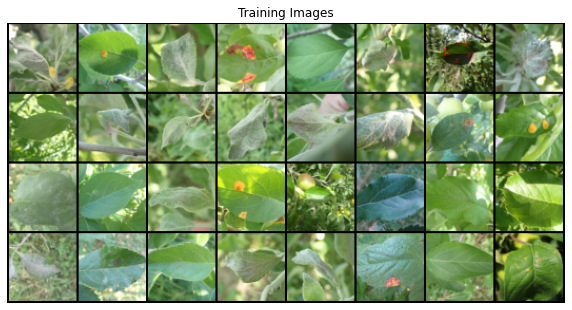

In [ ]:
#Plot some training images
batch = next(iter(train_loader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(batch[0].to(device)[:32], padding=2,
                                                    normalize=True).cpu(),(1,2,0)))

In [4]:
class Network(nn.Module):
  def __init__(self, l1=120, l2=60):
    super(Network, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = nf, kernel_size = 5, bias=False),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(),

        nn.Conv2d(nf, nf*2, 5, 1, 0, bias=False),
        nn.BatchNorm2d(nf*2),
        nn.LeakyReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(nf*2, nf*4,5,1,0, bias=False),
        nn.BatchNorm2d(nf*4),
        nn.LeakyReLU(),
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(nf*4*12*12, l1),
        nn.LeakyReLU(),

        nn.Linear(l1, l2),
        nn.LeakyReLU(),

        nn.Linear(l2, 3),
        nn.Softmax(dim=1)
    )

  def forward(self, input):
    return self.main(input)

In [5]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(network.parameters(), lr = lr)

NameError: ignored

In [ ]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
  total_loss = 0
  total_correct = 0
  for batch in train_loader:
    images, labels = batch 
    images, labels = images.to(device), labels.to(device)
    network.zero_grad()
    preds = network(images)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)

  print(f"epoch:", epoch, "total_correct:", total_correct, "total_loss", total_loss, "accuracy:", total_correct/len_train_set)

Starting Training Loop...
epoch: 0 total_correct: 908 total_loss 35.977504193782806 accuracy: 0.686838124054463
epoch: 1 total_correct: 1052 total_loss 31.61446523666382 accuracy: 0.7957639939485628
epoch: 2 total_correct: 1074 total_loss 30.81505388021469 accuracy: 0.8124054462934948
epoch: 3 total_correct: 1042 total_loss 31.836443781852722 accuracy: 0.7881996974281392
epoch: 4 total_correct: 1009 total_loss 32.81120377779007 accuracy: 0.7632375189107413


First run of network with batchsize = 32, number of epoch = 5:


1.   epoch: 0 total_correct: 908 total_loss 35.977504193782806 accuracy: 0.686838124054463
2. epoch: 1 total_correct: 1052 total_loss 31.61446523666382 accuracy: 0.7957639939485628
3. epoch: 2 total_correct: 1074 total_loss 30.81505388021469 accuracy: 0.8124054462934948
4. epoch: 3 total_correct: 1042 total_loss 31.836443781852722 accuracy: 0.7881996974281392
5. epoch: 4 total_correct: 1009 total_loss 32.81120377779007 accuracy: 0.7632375189107413




## Hyperparamter Tuning


In [6]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter

/usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [ ]:
pip install -U ray

Requirement already up-to-date: ray in /usr/local/lib/python3.7/dist-packages (1.4.1)


In [ ]:
pip install tensorboardX

In [7]:
def load_data(data_dir='./data', img_size = 64):
  data_train = data_dir + '/Train'
  data_valid = data_dir + '/Validation'
  data_test = data_dir + '/Test'
  train_set = dset.ImageFolder(root=data_train,
                             transform = transforms.Compose([
                                                             transforms.Resize(img_size),
                                                             transforms.CenterCrop(img_size),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                             ]))
  valid_set = dset.ImageFolder(root=data_valid,
                               transform = transforms.Compose([
                                                               transforms.Resize(img_size),
                                                               transforms.CenterCrop(img_size),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                               ]))
  test_set = dset.ImageFolder(root=data_test,
                              transform = transforms.Compose([
                                                              transforms.Resize(img_size),
                                                              transforms.CenterCrop(img_size),
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                              ]))
  return train_set, valid_set, test_set

In [8]:
def train_data(config, checkpoint_dir = True, data_dir = None):
  network = Network(config["l1"], config["l2"])
  device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
  network.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(network.parameters(), lr=config['lr'])

  if checkpoint_dir:
    model_state, optimizer_state = torch.load(
        os.path.join(checkpoint_dir, "checkpoint"))
    network.load_state_dict(model_state)
    optimizer.load_state_dict(optimizer_sate)
  
  trainset, validset, testset = load_data(data_dir = data_dir)

  train_loader = torch.utils.data.DataLoader(
      trainset,
      batch_size= int(config['batch_size']),
      shuffle=True,
      num_workers = 2
  )
  val_loader = torch.utils.data.DataLoader(
    validset,
    batch_size= int(config['batch_size']),
    shuffle=True,
    num_workers = 2
  )

  for epoch in range(5):
    running_loss = 0.0
    epoch_steps = 0
    for i, data in enumerate(train_loader, 0):
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      preds = network(images)
      loss = criterion(preds, labels)
      loss.backward()
      optimizer.step()

      #printing statistics
      running_loss += loss.item()
      epoch_steps += 1
      if i % 2000 == 1999:
        print("[%d, %5d] loss: %.3f" % (epoch + 1, i+1, running_loss/epoch_steps))
        running_loss = 0.0
    
    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0
    for i, data in enumerate(val_loader, 0):
      with torch.no_grad():
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        preds = network(images)

        total += labels.size(0)
        correct += get_num_correct(preds, labels)

        loss = criterion(preds, labels)
        val_loss += loss.cpu().numpy()
        val_steps +=1
    with tune.checkpoint_dir(epoch) as checkpoint_dir:
      path = os.path.join(checkpoint_dir, "checkpoint")
      torch.save((network.state_dict(), optimizer.state_dict()), path)
    
    tune.report(loss=(val_loss/val_steps), accuracy=correct/total)
  print("Finished Training")

    


In [9]:
def test_data(network, device="cpu", data_dir = './data'):
  
  trainset, validset, testset = load_data(data_dir = data_dir)

  test_loader = torch.utils.data.DataLoader(
      testset, batch_size = 4, shuffle=True, num_workers = 2
  )

  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = network(images)
      total += labels.size(0)
      correct += get_num_correct(outputs, labels)
  return correct/total

In [ ]:
def main(data_dir='gdrive/My Drive/data/plant_disease'):
  load_data(data_dir=data_dir)
  config = {
      "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
      "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
      "lr": tune.loguniform(1e-4, 1e-1),
      "batch_size": tune.choice([8, 16, 32, 64])
  }


In [10]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial =0.5):
    data_dir = os.path.abspath("gdrive/My Drive/data/plant_disease")
    load_data(data_dir)
    config = {
      "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
      "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
      "lr": tune.loguniform(1e-4, 1e-1),
      "batch_size": tune.choice([8, 16, 32, 64])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_data, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Network(best_trial.config["l1"], best_trial.config["l2"])

    device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_data(best_trained_model, device, data_dir=data_dir)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=1)

2021-07-09 07:22:25,149	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265
2021-07-09 07:22:27,931	WARNING experiment.py:294 -- No name detected on trainable. Using DEFAULT.
2021-07-09 07:22:27,933	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Memory usage on this node: 1.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2021-07-09_07-22-27
Number of trials: 10/10 (10 PENDING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_6a5c5_00000 | PENDING  |       |            8 |   32 |   64 | 0.0449811   |
| DEFAULT_6a5c5_00001 | PENDING  |       |           32 |  256 |   32 | 0.00578709  |
| DEFAULT_6a5c5_00002 | PENDING  |       |           32 |   64 |    8 | 0.0199191   |
| DEFAULT_6a5c5_00003 | PENDING  |       |           32 |   16 |  256 | 0.00336433  |
| DEFAULT_6a5c5_0

(pid=2556) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=2556)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0.5/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/2.0 CPU_group_0_6ff0dda2bc6172089e4dc77154f91be9, 0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_6ff0dda2bc6172089e4dc77154f91be9)
Result logdir: /root/ray_results/DEFAULT_2021-07-09_07-22-27
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_6a5c5_00000 | RUNNING  |       |            8 |   32 |   64 | 0.0449811   |
| DEFAULT_6a5c5_00001 | PENDING  |       |           32 |  256 |   32 | 0.00578709  |
| DEFAULT_6a5c5_00002 | PENDING  |       |           32 |   64 |    8

(pid=2555) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=2555)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_6a5c5_00001:
  accuracy: 0.3333333333333333
  date: 2021-07-09_07-42-39
  done: true
  experiment_id: 8ae30c7db1574fb0900e2a5b0873047f
  hostname: f432a3f343b4
  iterations_since_restore: 1
  loss: 1.2255520224571228
  node_ip: 172.28.0.2
  pid: 2555
  should_checkpoint: true
  time_since_restore: 203.29726099967957
  time_this_iter_s: 203.29726099967957
  time_total_s: 203.29726099967957
  timestamp: 1625816559
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6a5c5_00001
  
== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: -1.2389447018504143 | Iter 2.000: -1.2389446720480919 | Iter 1.000: -1.2244358472526073
Resources requested: 2.0/2 CPUs, 0.5/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/2.0 CPU_group_6ff0dda2bc6172089e4dc77154f91be9, 0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_0_6ff0dda2bc6172089e4dc77154f91be9)
Result logdir: /root/ray_results/DEFAULT_2021-0

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=3023) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=3023)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_6a5c5_00002:
  accuracy: 0.3333333333333333
  date: 2021-07-09_07-46-03
  done: false
  experiment_id: d9c39dad318b460398d879367047559e
  hostname: f432a3f343b4
  iterations_since_restore: 1
  loss: 1.2166234254837036
  node_ip: 172.28.0.2
  pid: 3023
  should_checkpoint: true
  time_since_restore: 202.95954585075378
  time_this_iter_s: 202.95954585075378
  time_total_s: 202.95954585075378
  timestamp: 1625816763
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6a5c5_00002
  
== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: -1.2389447018504143 | Iter 2.000: -1.2389446720480919 | Iter 1.000: -1.2233196720480919
Resources requested: 2.0/2 CPUs, 0.5/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/2.0 CPU_group_6ff0dda2bc6172089e4dc77154f91be9, 0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_0_6ff0dda2bc6172089e4dc77154f91be9)
Result logdir: /root/ray_results/DEFAULT_2021-

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=3384) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=3384)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_6a5c5_00003:
  accuracy: 0.3333333333333333
  date: 2021-07-09_08-02-43
  done: false
  experiment_id: abb205b45fd248c394e1787031a4c3a2
  hostname: f432a3f343b4
  iterations_since_restore: 1
  loss: 1.218855619430542
  node_ip: 172.28.0.2
  pid: 3384
  should_checkpoint: true
  time_since_restore: 202.22834658622742
  time_this_iter_s: 202.22834658622742
  time_total_s: 202.22834658622742
  timestamp: 1625817763
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6a5c5_00003
  
== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: -1.2266679964959621 | Iter 2.000: -1.2311322800815105 | Iter 1.000: -1.221087645739317
Resources requested: 2.0/2 CPUs, 0.5/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/2.0 CPU_group_6ff0dda2bc6172089e4dc77154f91be9, 0.0/2.0 CPU_group_0_6ff0dda2bc6172089e4dc77154f91be9, 0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2021-07

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=3741) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=3741)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_6a5c5_00004:
  accuracy: 0.8
  date: 2021-07-09_08-19-32
  done: false
  experiment_id: 3347eecc057c4691ac2d51389888acd6
  hostname: f432a3f343b4
  iterations_since_restore: 1
  loss: 0.7848836183547974
  node_ip: 172.28.0.2
  pid: 3741
  should_checkpoint: true
  time_since_restore: 203.02206182479858
  time_this_iter_s: 203.02206182479858
  time_total_s: 203.02206182479858
  timestamp: 1625818772
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6a5c5_00004
  
== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: -1.218855619430542 | Iter 2.000: -1.2233198881149292 | Iter 1.000: -1.218855619430542
Resources requested: 2.0/2 CPUs, 0.5/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/2.0 CPU_group_6ff0dda2bc6172089e4dc77154f91be9, 0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_0_6ff0dda2bc6172089e4dc77154f91be9)
Result logdir: /root/ray_results/DEFAULT_2021-07-09_07-22-27
Nu

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=4097) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=4097)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_6a5c5_00005:
  accuracy: 0.3333333333333333
  date: 2021-07-09_08-36-16
  done: false
  experiment_id: ad50d5c60b7e49a28c694c0076db1e87
  hostname: f432a3f343b4
  iterations_since_restore: 1
  loss: 1.207694798707962
  node_ip: 172.28.0.2
  pid: 4097
  should_checkpoint: true
  time_since_restore: 201.8825328350067
  time_this_iter_s: 201.8825328350067
  time_total_s: 201.8825328350067
  timestamp: 1625819776
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6a5c5_00005
  
== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: -1.216623455286026 | Iter 2.000: -1.2222038209438324 | Iter 1.000: -1.2177395224571228
Resources requested: 2.0/2 CPUs, 0.5/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_6ff0dda2bc6172089e4dc77154f91be9, 0.0/2.0 CPU_group_0_6ff0dda2bc6172089e4dc77154f91be9)
Result logdir: /root/ray_results/DEFAULT_2021-07-09

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=4260) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=4260)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_6a5c5_00006:
  accuracy: 0.8333333333333334
  date: 2021-07-09_08-43-02
  done: false
  experiment_id: 18c875c7382846b5a2f23173a2b344dd
  hostname: f432a3f343b4
  iterations_since_restore: 1
  loss: 0.7165088653564453
  node_ip: 172.28.0.2
  pid: 4260
  should_checkpoint: true
  time_since_restore: 204.31872010231018
  time_this_iter_s: 204.31872010231018
  time_total_s: 204.31872010231018
  timestamp: 1625820182
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6a5c5_00006
  
== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: -1.216623455286026 | Iter 2.000: -1.223319798707962 | Iter 1.000: -1.2166234254837036
Resources requested: 2.0/2 CPUs, 0.5/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/2.0 CPU_group_0_6ff0dda2bc6172089e4dc77154f91be9, 0.0/2.0 CPU_group_6ff0dda2bc6172089e4dc77154f91be9, 0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2021-07

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=4612) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=4612)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_6a5c5_00007:
  accuracy: 0.3333333333333333
  date: 2021-07-09_08-59-54
  done: false
  experiment_id: 6ec6bea7b1f24f809fb06e31a3772724
  hostname: f432a3f343b4
  iterations_since_restore: 1
  loss: 1.2129031121730804
  node_ip: 172.28.0.2
  pid: 4612
  should_checkpoint: true
  time_since_restore: 203.64334321022034
  time_this_iter_s: 203.64334321022034
  time_total_s: 203.64334321022034
  timestamp: 1625821194
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6a5c5_00007
  
== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: -1.21439129114151 | Iter 2.000: -1.2222037762403488 | Iter 1.000: -1.214763268828392
Resources requested: 2.0/2 CPUs, 0.5/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_6ff0dda2bc6172089e4dc77154f91be9, 0.0/2.0 CPU_group_0_6ff0dda2bc6172089e4dc77154f91be9)
Result logdir: /root/ray_results/DEFAULT_2021-07-

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=4773) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/co

Result for DEFAULT_6a5c5_00008:
  accuracy: 0.3333333333333333
  date: 2021-07-09_09-06-44
  done: true
  experiment_id: d5b06c3ae5a54b31918c7c04458a3657
  hostname: f432a3f343b4
  iterations_since_restore: 1
  loss: 1.2233196794986725
  node_ip: 172.28.0.2
  pid: 4773
  should_checkpoint: true
  time_since_restore: 206.45732617378235
  time_this_iter_s: 206.45732617378235
  time_total_s: 206.45732617378235
  timestamp: 1625821604
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6a5c5_00008
  
== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: None | Iter 4.000: -1.21439129114151 | Iter 2.000: -1.223319798707962 | Iter 1.000: -1.2166234254837036
Resources requested: 2.0/2 CPUs, 0.5/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_0_6ff0dda2bc6172089e4dc77154f91be9, 0.0/2.0 CPU_group_6ff0dda2bc6172089e4dc77154f91be9)
Result logdir: /root/ray_results/DEFAULT_2021-07-0

(pid=4777) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=4777)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_6a5c5_00009:
  accuracy: 0.7166666666666667
  date: 2021-07-09_09-10-11
  done: false
  experiment_id: 8969dfe3445b4720beaa5b4ee3172b9a
  hostname: f432a3f343b4
  iterations_since_restore: 1
  loss: 0.9149167314171791
  node_ip: 172.28.0.2
  pid: 4777
  should_checkpoint: true
  time_since_restore: 205.85073399543762
  time_this_iter_s: 205.85073399543762
  time_total_s: 205.85073399543762
  timestamp: 1625821811
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6a5c5_00009
  
== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: None | Iter 4.000: -1.21439129114151 | Iter 2.000: -1.223319798707962 | Iter 1.000: -1.214763268828392
Resources requested: 2.0/2 CPUs, 0.5/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/2.0 CPU_group_0_6ff0dda2bc6172089e4dc77154f91be9, 0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_6ff0dda2bc6172089e4dc77154f91be9)
Result logdir: /root/ray_results/DEFAULT_2021-07-0

2021-07-09 09:23:39,682	INFO tune.py:549 -- Total run time: 7271.75 seconds (7271.50 seconds for the tuning loop).


Result for DEFAULT_6a5c5_00009:
  accuracy: 0.8166666666666667
  date: 2021-07-09_09-23-39
  done: false
  experiment_id: 8969dfe3445b4720beaa5b4ee3172b9a
  hostname: f432a3f343b4
  iterations_since_restore: 5
  loss: 0.754903182387352
  node_ip: 172.28.0.2
  pid: 4777
  should_checkpoint: true
  time_since_restore: 1013.7730803489685
  time_this_iter_s: 202.91146326065063
  time_total_s: 1013.7730803489685
  timestamp: 1625822619
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 6a5c5_00009
  
== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: None | Iter 4.000: -0.9771061055362225 | Iter 2.000: -1.2222037762403488 | Iter 1.000: -1.214763268828392
Resources requested: 2.0/2 CPUs, 0.5/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/2.0 CPU_group_0_6ff0dda2bc6172089e4dc77154f91be9, 0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_6ff0dda2bc6172089e4dc77154f91be9)
Result logdir: /root/ray_results/DEFAULT_2021-07

FileNotFoundError: ignored